<a href="https://colab.research.google.com/github/intimanjunath/Decision-trees-and-ensemble/blob/main/Classic_GBM_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [11]:
# Helper function to compute standard deviation aggregate
def std_agg(cnt, s1, s2):
    return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)

# Decision Tree class for Gradient Boosting
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=2):
        if idxs is None:
            idxs = np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in range(self.c):
            self.find_better_split(i)
        if self.score == float('inf'):
            return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf')

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf:
            return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)


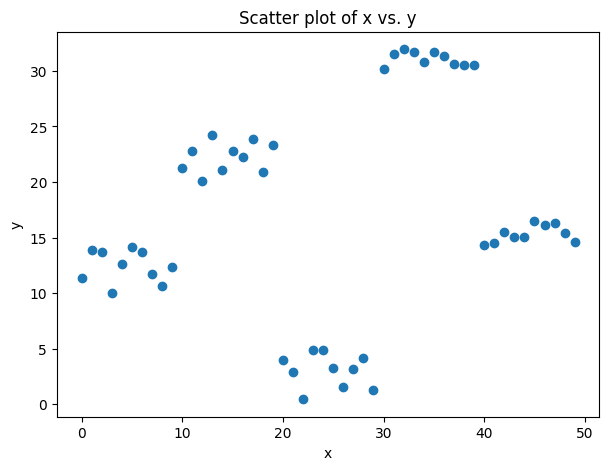

In [12]:
# Simulate Data
x = np.arange(0, 50)
x = pd.DataFrame({'x': x})

# Random uniform distributions
y1 = np.random.uniform(10, 15, 10)
y2 = np.random.uniform(20, 25, 10)
y3 = np.random.uniform(0, 5, 10)
y4 = np.random.uniform(30, 32, 10)
y5 = np.random.uniform(13, 17, 10)

y = np.concatenate((y1, y2, y3, y4, y5))
y = y[:, None]

# Scatter plot
plt.figure(figsize=(7, 5))
plt.plot(x, y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


<ipython-input-11-9f3e121cf169>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
<ipython-input-13-47364daaf92e>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 2.5))


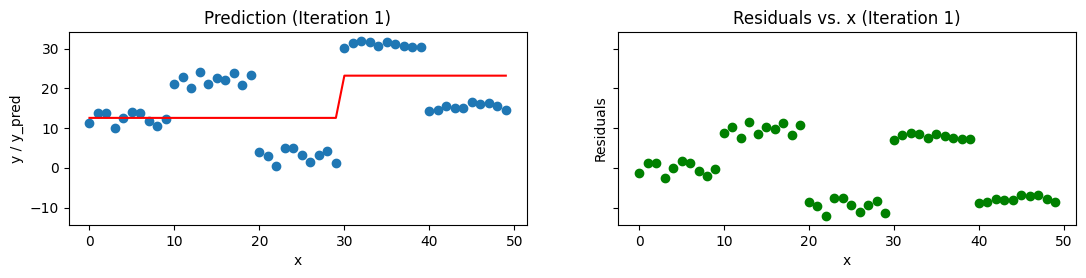

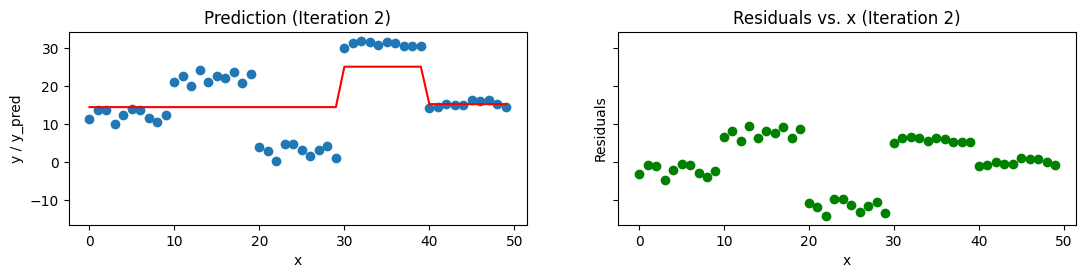

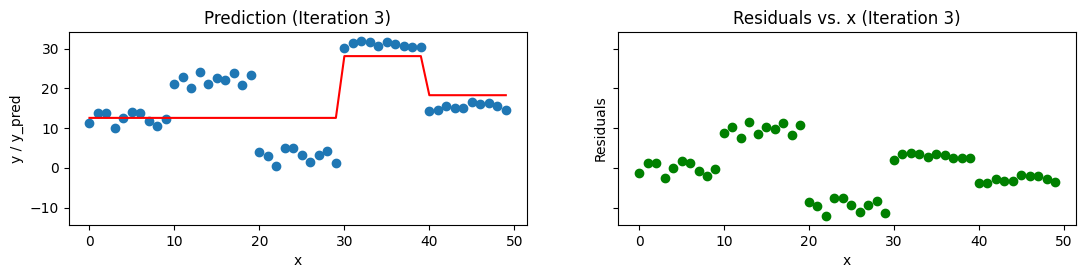

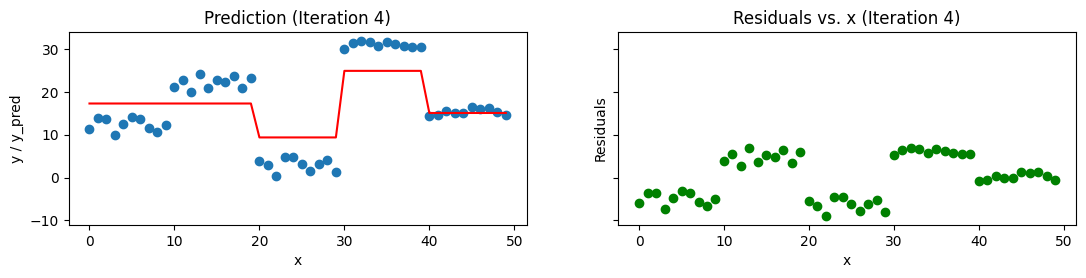

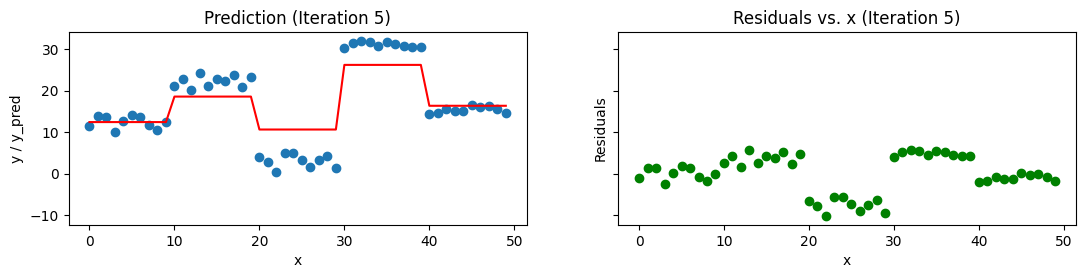

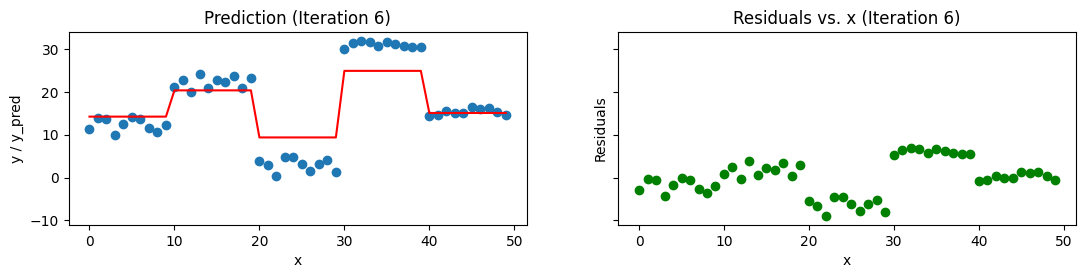

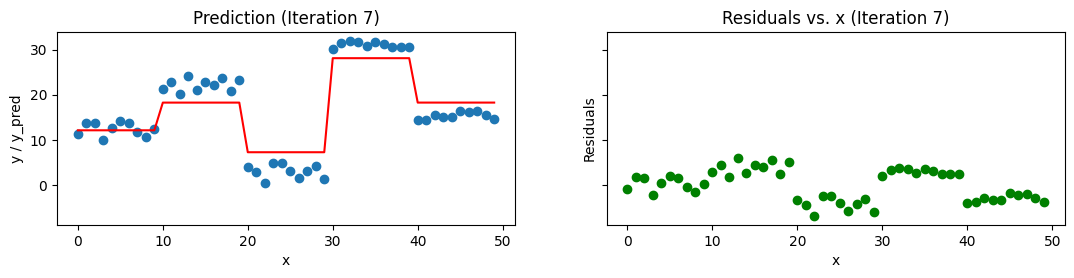

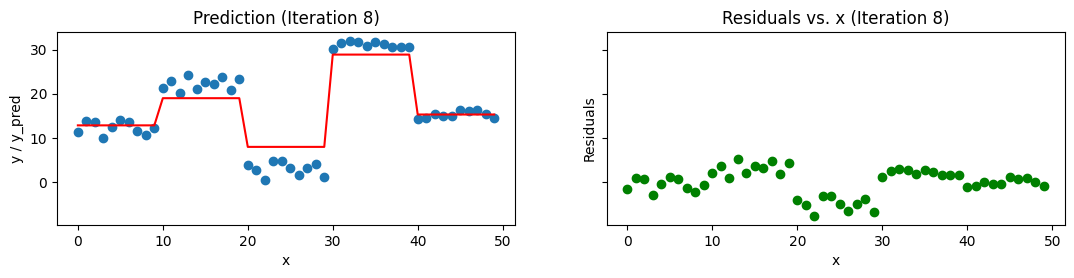

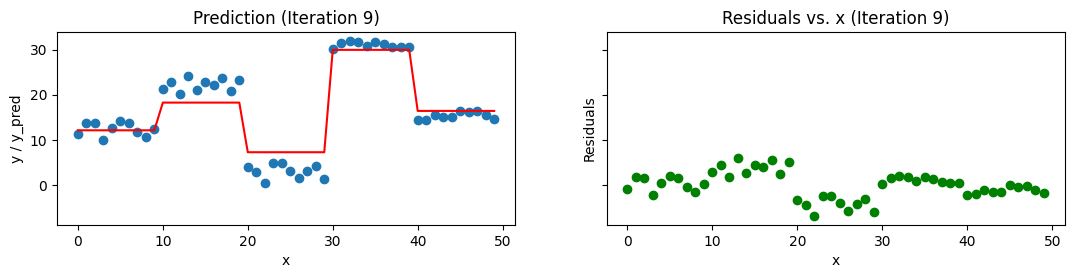

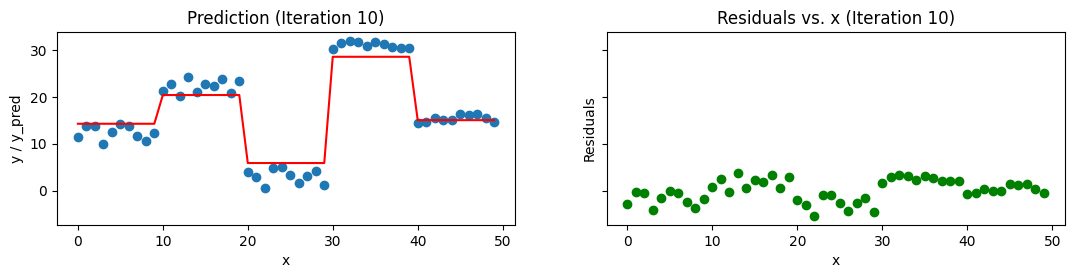

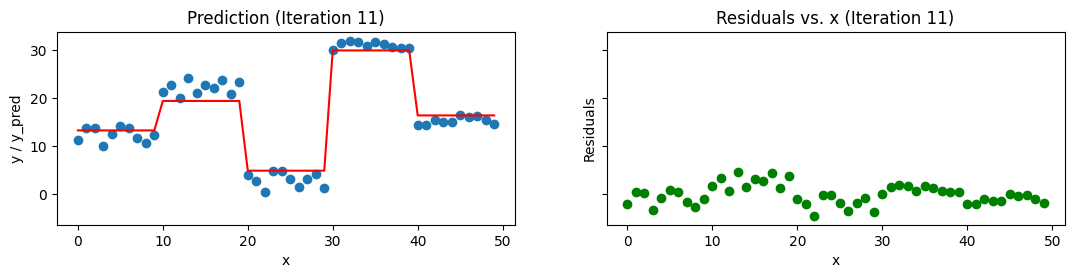

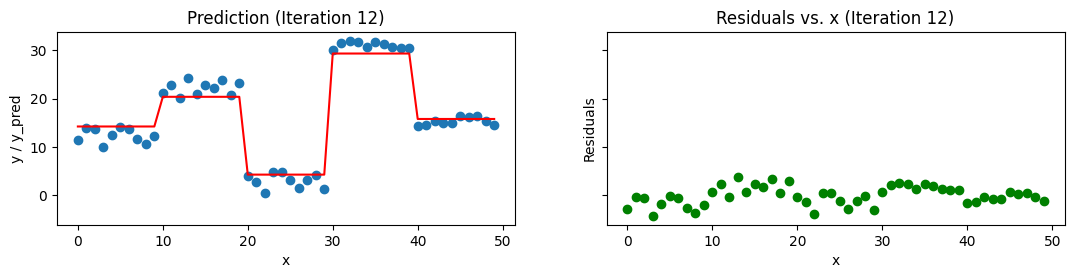

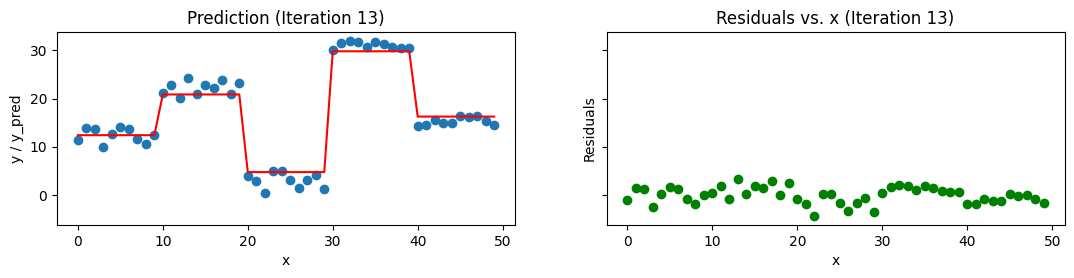

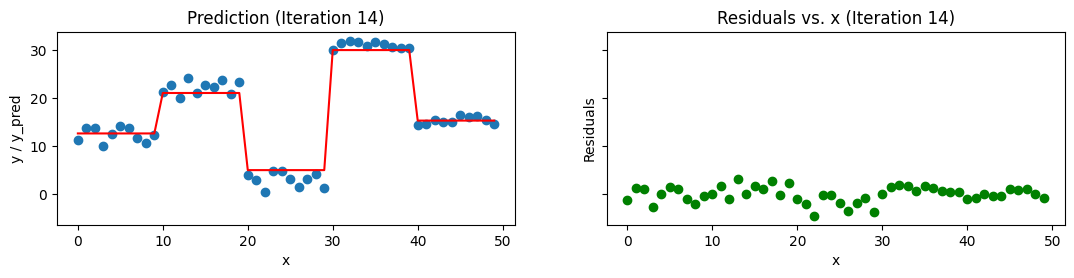

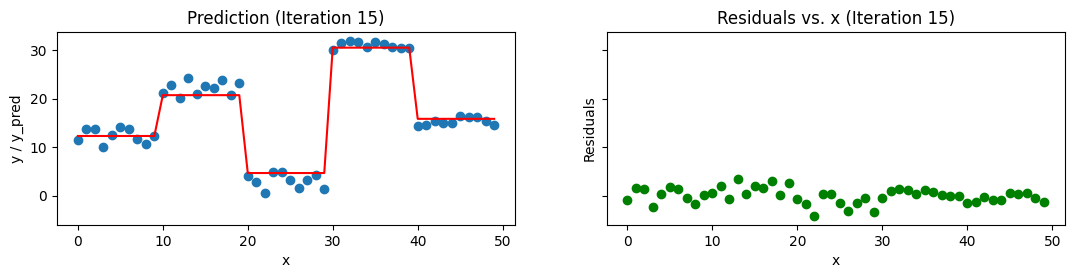

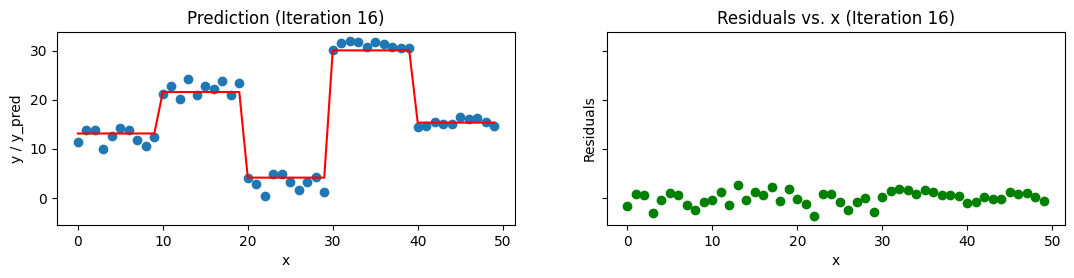

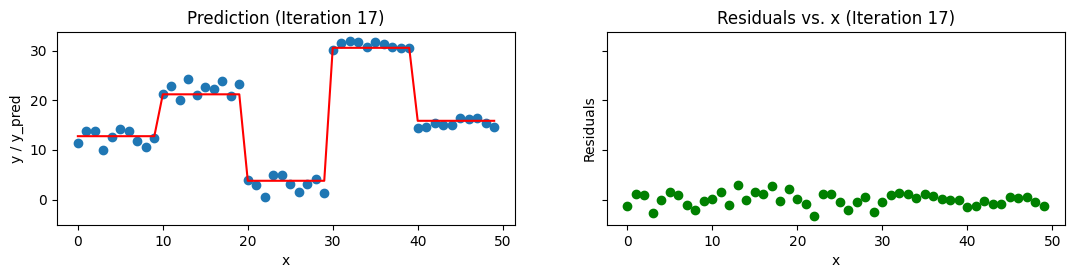

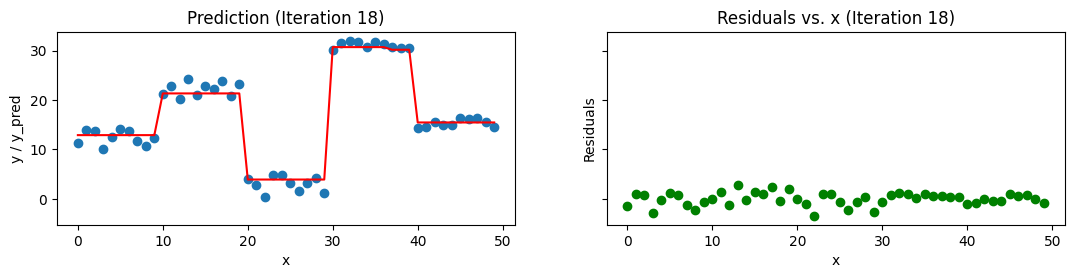

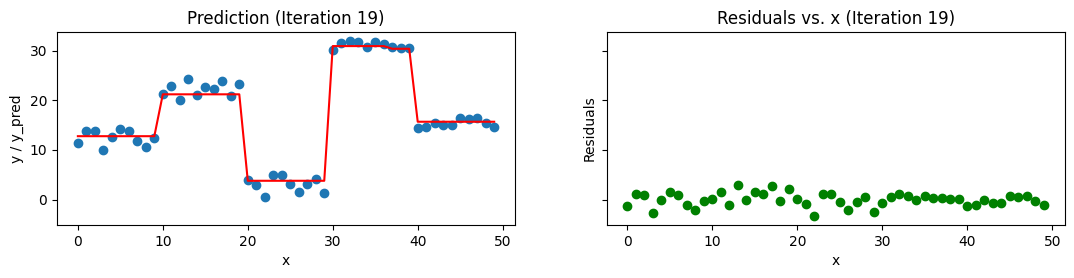

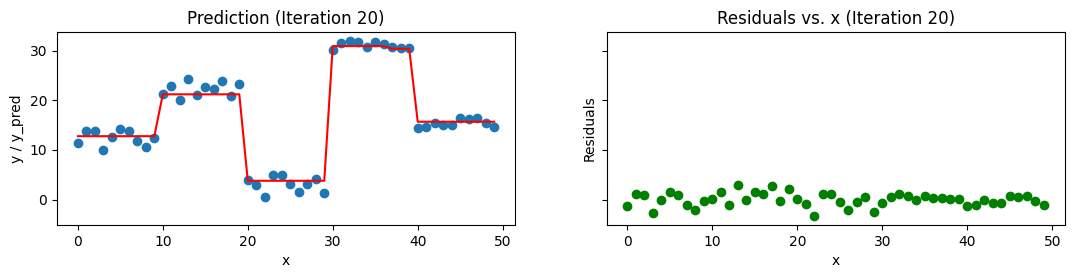

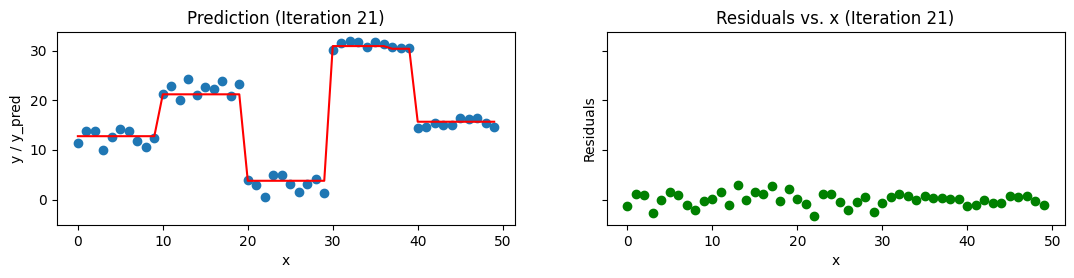

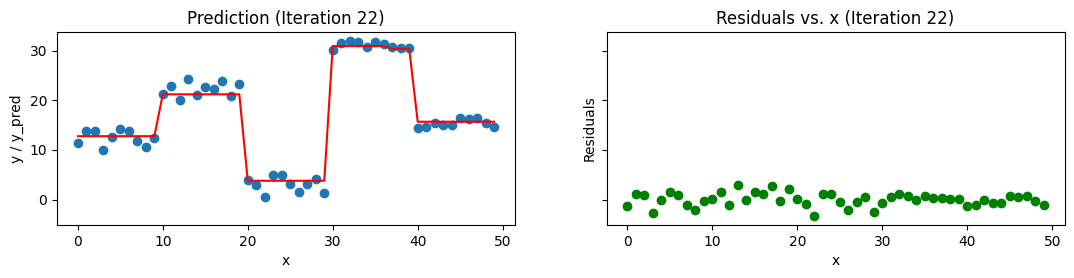

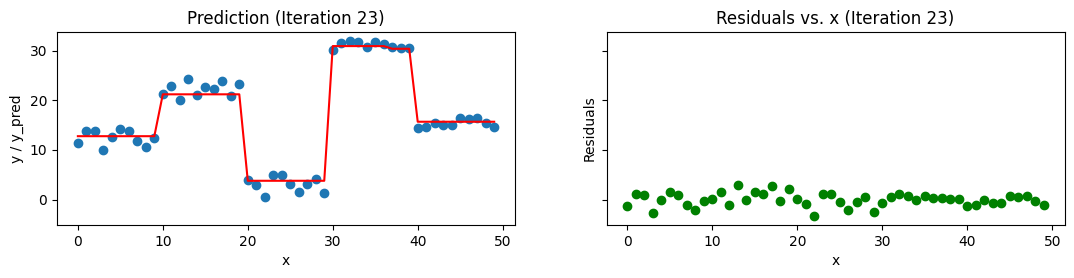

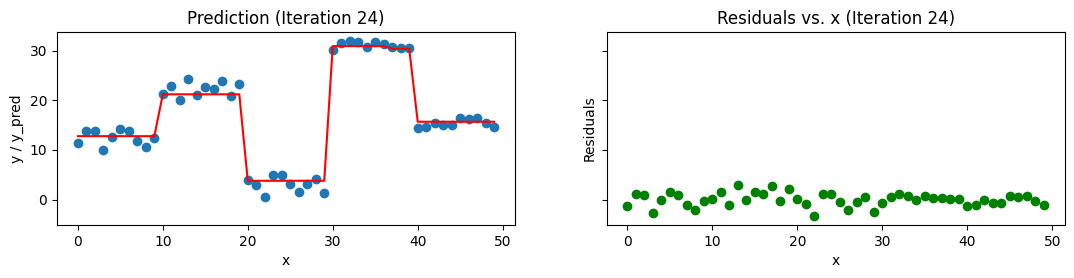

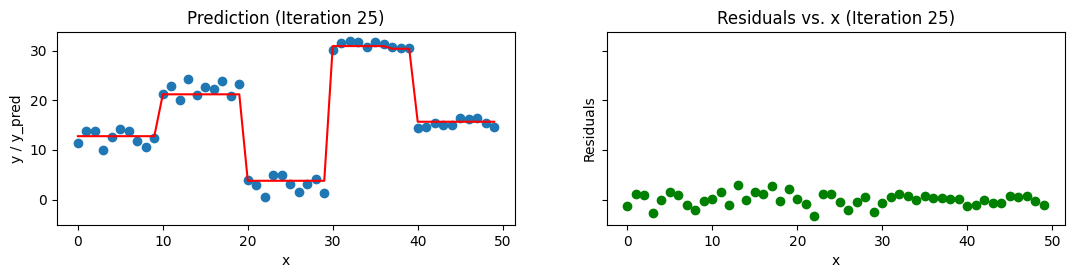

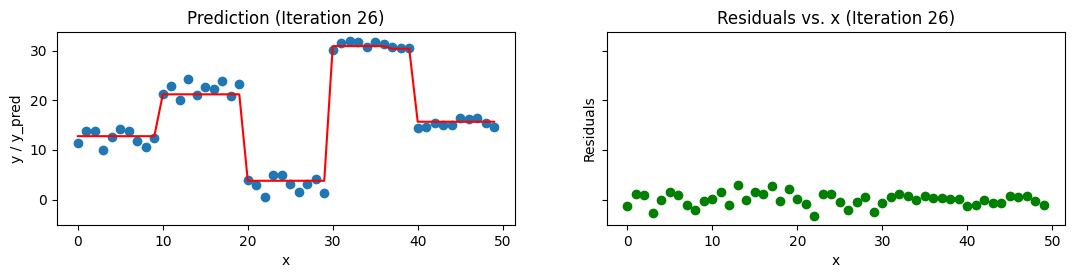

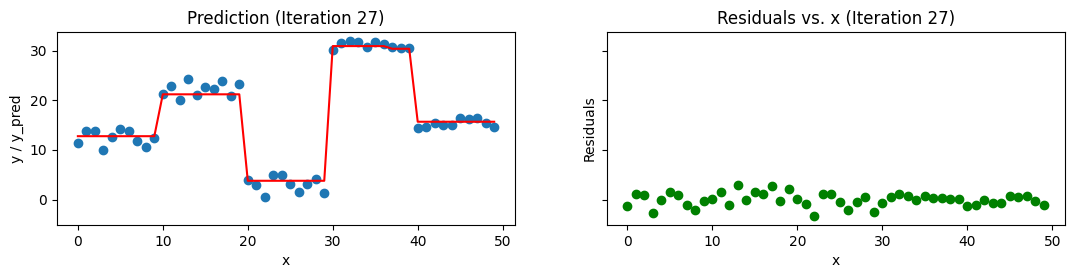

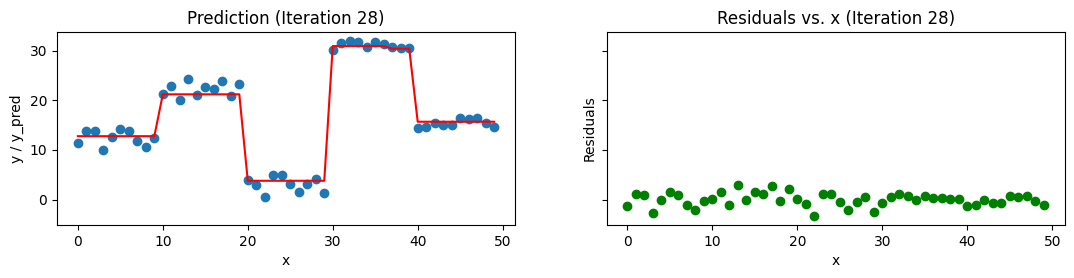

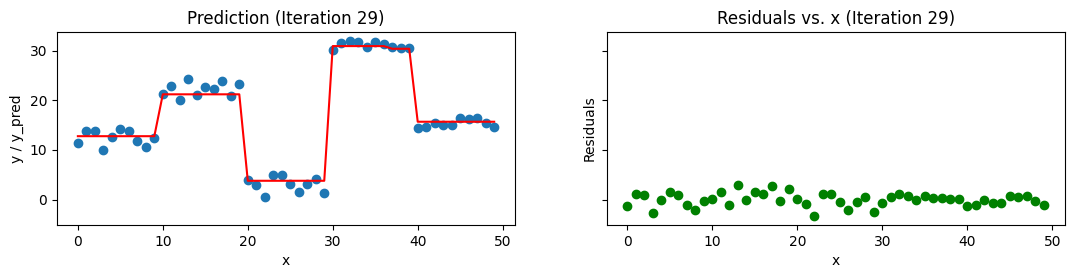

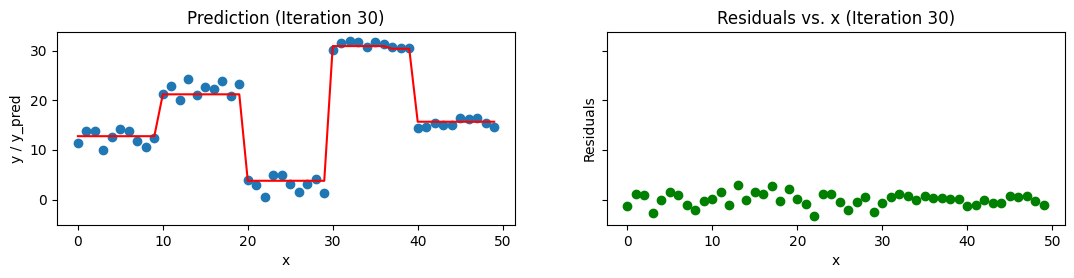

In [13]:
# Gradient Boosting Implementation
xi, yi = x, y  # Initialization of input and target
ei = 0         # Initialization of error
n = len(yi)    # Number of rows
predf = 0      # Initial prediction

for i in range(30):  # Number of estimators
    tree = DecisionTree(xi, yi)  # Fit a Decision Tree to residuals
    tree.find_better_split(0)    # Find the best split

    r = np.where(xi == tree.split)[0][0]  # Find index of best split

    left_idx = np.where(xi <= tree.split)[0]  # LHS indices
    right_idx = np.where(xi > tree.split)[0]  # RHS indices

    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n - r))

    predi = predi[:, None]
    predf = predf + predi  # Update predictions

    ei = y - predf        # Update residuals
    yi = ei               # Use residuals for next tree

    # Visualization of predictions and residuals
    xa = np.array(x.x)
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 2.5))
    ax1.plot(x, y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title(f'Prediction (Iteration {i + 1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title(f'Residuals vs. x (Iteration {i + 1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')
plt.show()


In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# 1. Generate a sample regression dataset
X, y = make_regression(n_samples=500, n_features=1, noise=15, random_state=42)
y = y.reshape(-1, 1)

In [3]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
#Define the Gradient Boosting Machine class
class GBM:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.initial_prediction = None

    def fit(self, X, y):
        # Step 1: Initialize with the mean of the target variable
        self.initial_prediction = np.mean(y)
        predictions = np.full(y.shape, self.initial_prediction)

        # Step 2: Train trees sequentially
        for _ in range(self.n_estimators):
            # Compute residuals
            residuals = y - predictions

            # Train a weak learner (decision tree regressor) on residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Predict residuals using the trained tree
            residual_predictions = tree.predict(X).reshape(-1, 1)

            # Update predictions
            predictions += self.learning_rate * residual_predictions

            # Store the model
            self.models.append(tree)

    def predict(self, X):
        # Start with the initial prediction
        predictions = np.full((X.shape[0], 1), self.initial_prediction)

        # Add contributions from each tree
        for tree in self.models:
            predictions += self.learning_rate * tree.predict(X).reshape(-1, 1)

        return predictions

In [5]:
# 3. Train the GBM model
gbm = GBM(n_estimators=50, learning_rate=0.1, max_depth=3)
gbm.fit(X_train, y_train)

In [6]:
# 4. Make predictions
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

In [7]:
# 5. Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

In [8]:
print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Train MSE: 161.82
Test MSE: 210.46


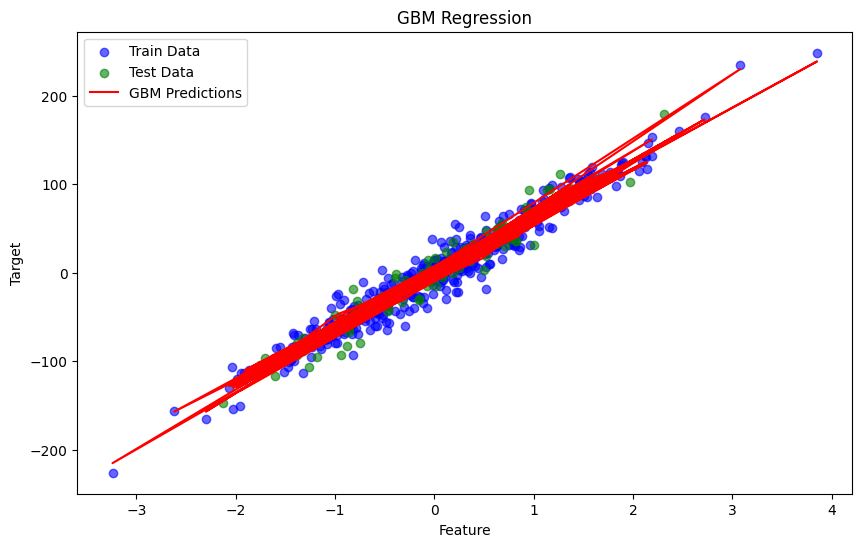

In [9]:
# 6. Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color="blue", label="Train Data", alpha=0.6)
plt.scatter(X_test, y_test, color="green", label="Test Data", alpha=0.6)
plt.plot(X_train, y_train_pred, color="red", label="GBM Predictions")
plt.title("GBM Regression")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.legend()
plt.show()